# Chapter 3

Selected exercises from ISLR - Chapter 3. Solutions are written in python.

First, let's import all the packages required to run the exercises below.

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import math
from scipy import stats
import statsmodels.api as sm
import scipy.stats
import copy
from sklearn.preprocessing import OneHotEncoder
from prettytable import PrettyTable
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures

Links to the exercises in this notebook: <br>
[Exercise 8](#exercise-8) <br>
[Exercise 9](#exercise-9) <br>
[Exercise 10](#exercise-10) <br>
[Exercise 11](#exercise-11) <br>
[Exercise 13](#exercise-13) <br>
[Exercise 14](#exercise-14) <br>
[Exercise 15](#exercise-15) <br>

<a id='exercise-8'></a>
## Exercise 8

This question involves the use of linear regression on the `Auto` dataset. \
As described in [Chapter 2](https://nbviewer.jupyter.org/github/maurock/ISLR/blob/main/Chapter_2.ipynb), null values in this dataset are represented by the question mark `?` \
Also, horsepower is of type `object`. We need to convert it into a quantitative feature.

In [2]:
auto = pd.read_csv('data/Auto.csv')
auto.drop(auto[auto.values == '?'].index, inplace = True)
auto['horsepower'] = pd.to_numeric(auto['horsepower'])

### 8.a - 8b
This question asks to fit a linear regression with `mpg` as response and `horsepower` as predictor. Then, it asks to analyze the relationship between the two features. Instead of using `scikit-learn.linear_model.LinearRegression()`, I define my own model from scratch for learning purposes. The coefficients are computed using linear algebra.

#### Quick refresher on Linear Regression using Linear Algebra.  <span style="background-color: #FFC300">[Theory]</span>
We group all the observations of the response in a column vector $\mathrm{y}$, while the observations of the predictor are grouped in a matrix $\mathrm{x}$. A linear model is expressed as: \
$$ y = \mathrm{x} A $$ \
where $A$ is a matrix that groups the coefficient of the linear regression model.

In this case, the matrices are: 

$\mathrm{y} = \begin{bmatrix}y_1 \\ .. \\ .. \\ y_n \end{bmatrix}$  &nbsp; &nbsp; &nbsp; $\mathrm{x} = \begin{bmatrix}1 & x_1 \\ 1 & .. \\ 1 & .. \\ 1 & x_n \end{bmatrix}$   &nbsp; &nbsp; &nbsp;  $\mathrm{A} = \begin{bmatrix}\beta_0 \\ \beta_1 \end{bmatrix}$ 

The $\mathrm{x}$ matrix is also called _design matrix_. The first column, which only contains 1s, is necessary to derive the intercept. \
Adopting matrix calculus, we can calculate $A$ as follows: 

$$ y = x A $$

$$ x^T y = x^T x A $$

$$ (x^T x)^{-1} x^T y = (x^T x)^{-1} x^T x A $$

$$ A = (x^T x)^{-1} x^T y $$



In [3]:
class Linear_Regression:
    def __init__(self):
        """
        Initialize parameters of the linear regression model. 
        In the lists, the first element refers to the intercept and the secon element refers to the coefficient.
        """
        self.intercept = None
        self.slope = None
        self.A = None
        self.t_statistics = []
        self.p_values = []
        self.SE = []
        
    def fit(self, x, y, print_statistics=False):
        """
        This function fits a linear regression model and stores the intercept and the coefficients.
        The arrays x and y are assumed to be row vectors.
        """
        X = np.zeros((x.shape[0], 2))
        X[:, 0] = 1
        X[:, 1] = x
        Y = y.reshape(-1, 1)
        self.A = np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(), X)), X.transpose()), Y)
        self.intercept, self.slope = self.A[0], self.A[1]
        self.N = x.shape[0]
        if print_statistics:
            self._hypothesis_testing(x, y)
        
    def predict(self, x):
        """
        This function predicts the response using the regression model.
        input x: row array, shape=(1, N) 
        output: column array, shape=(N, 1)
        """
        X = np.zeros((x.shape[0], 2))
        X[:, 0] = 1
        X[:, 1] = x
        return np.dot(X, self.A)
    
    def _hypothesis_testing(self, x, y):
        """
        Print a table for the t-statistics and p-value of the regression coefficients.
        The standard error of the parameters SE(..) are reported on page 66. 
        The t-scores of the parameters are calculated as B / SE(B).
        p-values are computed using a 2 sample t-test and N-2 degrees of freedom       
        """  
        N = y.shape[0]
        std_dev = math.sqrt(np.sum((y - np.ravel(self.predict(x)))**2) / (N - 1))    
        # Intercept -----------------
        # SE on page 66
        self.SE_intercept = std_dev * math.sqrt(1 / N + (np.mean(x)**2 / (np.sum((x - np.mean(x))**2))))
        
        # t-statistics to test null-hypothesis: coeff - 0 / SE(coeff)
        t_intercept = self.intercept / self.SE_intercept
        
        # p-value using stats.t.sf is looking up on a table with N - 2 dof, multiplied by 2 for the two-sided p-value
        p_intercept = stats.t.sf(np.abs(t_intercept), N - 2) * 2
        
        # Slope -----------------
        self.SE_slope = std_dev / math.sqrt(np.sum((x - np.mean(x))**2))
        t_slope = self.slope / self.SE_slope        
        p_slope = stats.t.sf(np.abs(t_slope), N - 2) * 2       
        
        # Print value
        df_statistics = pd.DataFrame(data = {'': ['intercept', 'slope'],
                                             'values': [self.intercept[0], self.slope[0]],
                                             'standard error': [self.SE_intercept, self.SE_slope],
                                             't-statistic': [t_intercept[0], t_slope[0]],
                                             'p-value': [p_intercept[0], p_slope[0]]})
                                             
        print(df_statistics)
        
    def print_model(self):
        print(f'The linear model is: y = {lm.slope[0]} x + {lm.intercept[0]}')

In [4]:
x = auto['horsepower'].values
y = auto['mpg'].values
lm = Linear_Regression()
lm.fit(x, y, print_statistics = True)
print()
lm.print_model()

                 values  standard error  t-statistic        p-value
0  intercept  39.935861        0.716581    55.731154  7.830299e-188
1      slope  -0.157845        0.006437   -24.520511   5.192580e-81

The linear model is: y = -0.15784473335365387 x + 39.9358610211705


To confirm that the values computed are the correct ones, I check with the library `statsmodels`:

In [5]:
X = sm.add_constant(x)
models = sm.OLS(y, X)
result_sm = models.fit()
print(result_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           7.03e-81
Time:                        21:51:51   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.0

The values I computed are then confirmed. <br>
The p-values for the intercept and the slope are < 0.05, thus they are significant. 

Let's see if the intercept and slope values I calculated using Linear Algebra are correct. The model in `scikit-learn` requires as input - for both x and y - arrays of shape (N, 1), where N is the number of datapoints to fit:

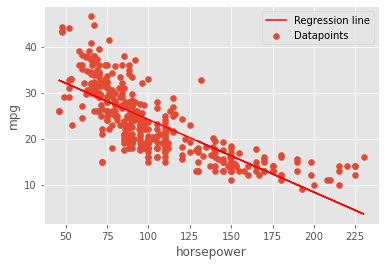

The regression line is: 
 y = -0.15784473335365365 x + 39.93586102117047


In [6]:
lm_sklearn = LinearRegression().fit(auto['horsepower'].values.reshape(-1, 1), auto['mpg'].values.reshape(-1, 1))
plt.scatter(auto['horsepower'].values, auto['mpg'].values)
# To plot the linear regression model:
x = auto['horsepower'].values
y_pred = lm_sklearn.predict(x.reshape(-1, 1))
plt.plot(x, y_pred, color='r')
plt.legend(['Regression line', 'Datapoints'])
plt.xlabel('horsepower')
plt.ylabel('mpg')
plt.show()
# Regression line coefficients:
print(f'The regression line is: \n y = {lm_sklearn.coef_[0][0]} x + {lm_sklearn.intercept_[0]}')

Using `scikit-learn` (below), we obtain the same results!

The relationship between the predictor and the response can be expressed by the $R^2$ measure: 

In [7]:
# R = (1 - RSS/TSS)
RSS = np.sum((y.reshape(-1, 1) - lm.predict(x))**2)
TSS = np.sum((y.reshape(-1, 1) - np.mean(y))**2)
r2 = 1 - RSS/TSS
print(f"R2 score: {r2}")

R2 score: 0.6059482578894348


There is a relationship between the predictor and the response, but this relationship does not seem to be linear. \
As done earlier, let's confirm that the value of $R^2$ I calculated is correct by checking the `sklearn.metrics` library:

In [8]:
# The R^2 score is computed as r2_score(y_true, y_pred)
r2 = r2_score(auto['mpg'], y_pred)
print(f'The R^2 score is: {r2}')

The R^2 score is: 0.6059482578894348


The predicted `mpg` for `horsepower` = 98 is:

In [9]:
result = lm.predict(np.array([98]))[0][0]
print(result)

24.467077152512424


The last question asks the associated *confidence intervals* and *prediction intervals*. 

#### Confidence interval <span style="background-color: #FFC300">[Theory]</span>
The confidence interval (CI) represents an interval that includes with X% probability **the mean** of the all the predicted values $\hat{y}$ for a given $x$. A 95% CI means that, if we calculate the linear regression model 100 times on random samples, the interval will contain the mean $\hat(y)$ for any value in the $x$ domain 95 times. 

The 95% confidence interval is calculated as follows: 

$$ \hat{y} \pm t_{\alpha \ / \ 2 } \ s_{\hat{y}}$$

where $t_{\alpha \ / \ 2 }$ is the t-statistics for $\text{dof} = N-2$, and $s_{\hat{y}}$ is the estimated standard deviation of $\hat{y}$. 
The value $s_{\hat{y}}$ is calculated as:

$$ s_{\hat{y}} = \sigma \sqrt{ \frac{1}{N} + \frac{(x^* - \overline{x})^2}{\sum{(x_i - \overline{x}})^2} }$$ 

where $x^*$ is represents every value on the $x$-axis and $\overline{x}$ is the mean of $x$.


#### Prediction interval <span style="background-color: #FFC300">[Theory]</span>
The prediction interval (CI) represents an interval that includes with X% probability **the actual prediction** for a given $x$. This is different than before, where we were focusing on the mean of the predictions. A 95% PI means that, if we calculate the linear regression model 100 times on random samples, the interval will contain the 95 predictions for that given $x$.

The 95% prediction interval is calculated as follows: 

$$ \hat{y}^* \pm t_{\alpha \ / \ 2 } \ s_{pred}$$

where $t_{\alpha \ / \ 2 }$ is the t-statistics for $\text{dof} = N-2$, and $s_{pred}$ is the estimated standard deviation of $\hat{y}^*$. 

$$ s_{pred}^2 = s_{\hat{y}}^2 + \sigma^2 $$

Then, $s_{pred}$ is calculated as:

$$ s_{pred} = \sigma \sqrt{1 + \frac{1}{N} + \frac{(x^* - \overline{x})^2}{\sum{(x_i - \overline{x}})^2} }$$ 

---


Using this formula, the 95% CI for `horsepower` = 98 is:

In [10]:
value_horsepower = 98
x = auto['horsepower'].values
y = auto['mpg'].values

# Method for CI 95%
def conf_int_95(x, y, value):
    N = x.shape[0]
    y_hat = np.ravel(lm.predict(x))
    std_dev = math.sqrt(np.sum((y - y_hat)**2) / (y.shape[0] - 1))
    # Compute using formula above
    s_yhat = std_dev * math.sqrt((1 / N) + ((value - np.mean(x))**2 / np.sum((x - np.mean(x))**2)))

    # Prediction
    predicted_value = lm.predict(np.array([value]))[0][0]    #[0][0] necessary because it returns [[value]]

    # Calculate lower and upper bounds for 95% CI
    CI_lower_bound = predicted_value - 2 * s_yhat     # t ~ 2 with so many dof (N - 2)
    CI_upper_bound = predicted_value + 2 * s_yhat    # t ~ 2 with so many dof (N - 2)
    return np.array([CI_lower_bound, CI_upper_bound])

# print result
print(f'The 95% confidence interval is: [{conf_int_95(x, y, value_horsepower)[0]}, {conf_int_95(x, y, value_horsepower)[1]}]')

The 95% confidence interval is: [23.96519548226853, 24.968958822756317]


In [11]:
# Method for PI 95%
def pred_int_95(x, y, value):
    N = x.shape[0]
    y_hat = np.ravel(lm.predict(x))
    std_dev = math.sqrt(np.sum((y - y_hat)**2) / (y.shape[0] - 1))
    # Compute using formula above
    s_yhat_pred = std_dev * math.sqrt(1 + ((1 / N) + (value - np.mean(x))**2 / np.sum((x - np.mean(x))**2)))
    predicted_value = lm.predict(np.array([value]))[0][0]    #[0][0] necessary because it returns [[value]]
    PI_lower_bound = predicted_value - 2 * s_yhat_pred     # t ~ 2 with so many dof (N - 2)
    PI_upper_bound = predicted_value + 2 * s_yhat_pred    # t ~ 2 with so many dof (N - 2)
    return np.array([PI_lower_bound, PI_upper_bound])

print(f'The 95% prediction interval is: [{pred_int_95(x, y, value_horsepower)[0]}, {pred_int_95(x, y, value_horsepower)[1]}]')

The 95% prediction interval is: [14.65527380532948, 34.27888049969537]


The plot of the confidence interval and prediction interval is:

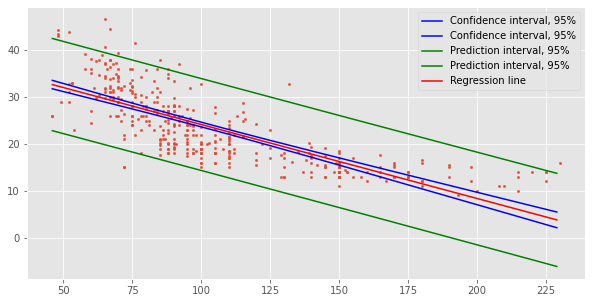

In [12]:
lm = Linear_Regression()
lm.fit(x, y, print_statistics = False)
predicted_values_line = lm.predict(np.arange(np.amin(auto['horsepower'].values), np.amax(auto['horsepower'].values), 1))
array_conf_intervals = []
array_pred_intervals = []
for i in range(np.amin(auto['horsepower'].values), np.amax(auto['horsepower'].values)):    # loop over x values  
    array_conf_intervals.append(conf_int_95(x, y, i))
    array_pred_intervals.append(pred_int_95(x, y, i))

plt.figure(figsize=(10, 5))
plt.plot(np.arange(np.amin(auto['horsepower'].values), np.amax(auto['horsepower'].values)), array_conf_intervals, c='b', label='Confidence interval, 95%')
plt.plot(np.arange(np.amin(auto['horsepower'].values), np.amax(auto['horsepower'].values)), array_pred_intervals, c='g', label='Prediction interval, 95%')
plt.plot(np.arange(np.amin(auto['horsepower'].values), np.amax(auto['horsepower'].values)), predicted_values_line, c='r', label='Regression line')
plt.scatter(auto['horsepower'].values, auto['mpg'].values, s=5)
plt.legend()
plt.show()

### 8.c

This question asks to analyze the result of the R function `lm().plot()`, that plots the Residual Analysis. \
Since I am not using R, I will develop a few methods to simulate the R `lm().plot()`: specifically, I will plot the *Residuals vs. Fitted*, *(Studentized) Residuals vs. Fitted* and the *Normal Q-Q*.

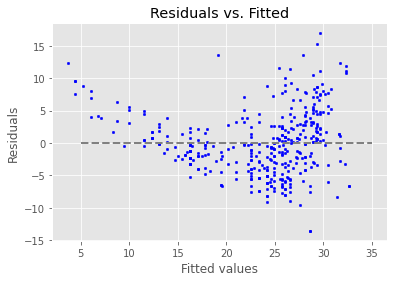

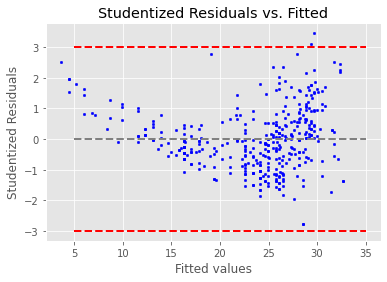

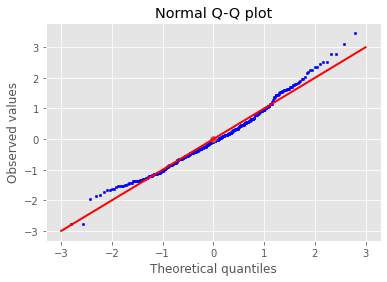

In [16]:
predictions = np.ravel(lm.predict(x))
residuals = y - np.ravel(predictions)

# Residuals vs. Fitted
def plot_lm(predictions, residuals):
    plt.plot([5, 35], [0, 0], '--', c='0.5', lw=2)
    #plt.xlim([40, 230])
    plt.scatter(predictions, residuals, s=6, c='b')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs. Fitted')
    plt.show()

    # Studentized Residuals vs. Fitted
    plt.plot([5, 35], [0, 0], '--', c='0.5', lw=2)
    plt.scatter(predictions, residuals / np.std(residuals), s=6, c='blue')
    plt.xlabel('Fitted values')
    plt.ylabel('Studentized Residuals')
    plt.title('Studentized Residuals vs. Fitted')
    plt.plot([5, 35], [3, 3] ,'r--', lw=2)
    plt.plot([5, 35], [-3, -3] ,'r--', lw=2)
    #plt.xlim([40, 230])
    plt.show()

    # Q-Q plot
    residuals_sorted = np.sort(residuals)
    studentized_residuals_sorted = np.sort(residuals/np.std(residuals))
    list_percentiles = [i / (len(residuals_sorted) + 1) for i in range(1, len(residuals_sorted) + 1)] 
    list_percentiles_expected_normal = scipy.stats.norm.ppf(list_percentiles)    # norm.ppf(X) is the gaussian value for the X-th percentile
    plt.scatter(list_percentiles_expected_normal, studentized_residuals_sorted, s=6, c='b')
    plt.plot([-3, 3], [-3, 3], 'r-', lw=2)
    plt.scatter([0], [0])
    plt.xlabel('Theoretical quantiles')
    plt.ylabel('Observed values')
    plt.title('Normal Q-Q plot')
    plt.show()
    
plot_lm(predictions, residuals)

As one can see:
- Residuals do not lie on the Q-Q line, thus they are not normally distributed.
- Heteroscedasticity: the variance is not constant. The linear model is not the best model that we could develop.
- Possible outliers: a few studentized residuals are higher than 3.

<a id='exercise-9'></a>
## Exercise 9

This exercise involves the use of multiple linear regression on the `Auto` dataset.

In [17]:
auto = pd.read_csv('data/Auto.csv')
auto.drop(auto[auto.values == '?'].index, inplace = True)
auto['horsepower'] = pd.to_numeric(auto['horsepower'])

### 9.a

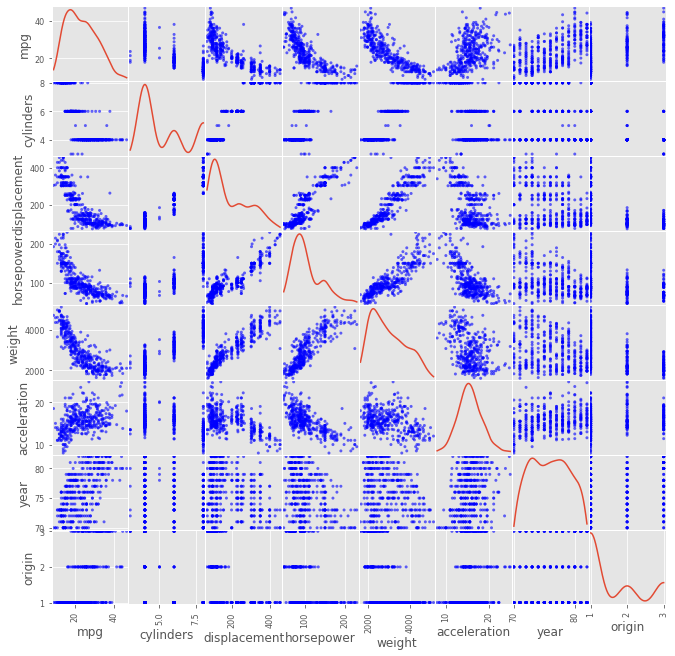

In [18]:
scatterplot = pd.plotting.scatter_matrix(auto, alpha = 0.6, figsize = (11, 11), diagonal = 'kde', color='blue')

### 9.b

This question asks to compute the correlation matrix. This can be done using the `pandas` method `corr()`: 

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


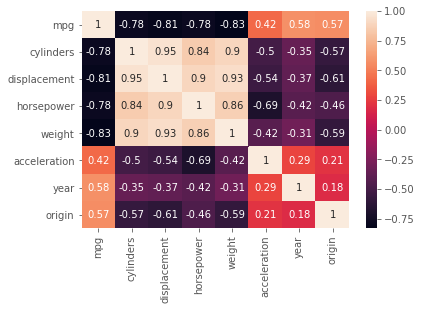

In [19]:
corr_matrix = auto.corr()    # Compute Pearson's correlation
display(corr_matrix)
sns.heatmap(corr_matrix, annot = True)
plt.show()

### 9.c

The question asks to perform multiple linear regression. To do so, I use the library `statsmodel`:

In [20]:
cols_regression = list(auto.columns)
cols_regression = list(set(cols_regression) - set(['name', 'mpg']))
cols_regression

['acceleration',
 'weight',
 'displacement',
 'year',
 'cylinders',
 'origin',
 'horsepower']

In [21]:
cols_regression = list(set(auto.columns) - set(['name', 'mpg']))   # all columns except 'name' and 'mpg'
X = auto[cols_regression]
X = sm.add_constant(X)
y = auto['mpg']
models = sm.OLS(y, X)
result_sm = models.fit()
print(result_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.4
Date:                Mon, 29 Mar 2021   Prob (F-statistic):          2.04e-139
Time:                        21:55:07   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.2184      4.644     -3.707   

Looking at the table, 5 predictors have a p-value < 0.05. This means that in 5 cases we can reject the null hypothesis that the coefficients are 0 (so, that there is not relationship among predictors and the response variable). <br>
The predictors that are statistically significant are: `weight, displacement, origin`, and `year`. <br>

The coefficient of the `year` variable suggests that there is an average increase of 0.7508 in `mpg` for a unit change in `year`.

### 9.d

I use the same method `plot_lm()` I defined earlier in Exercise 8:

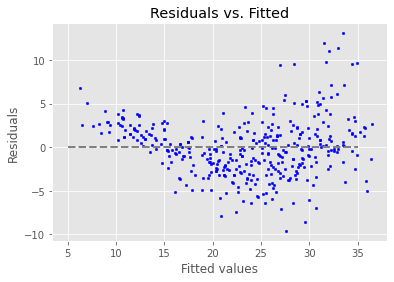

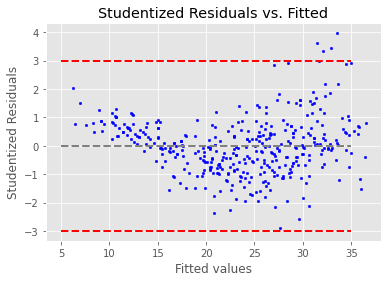

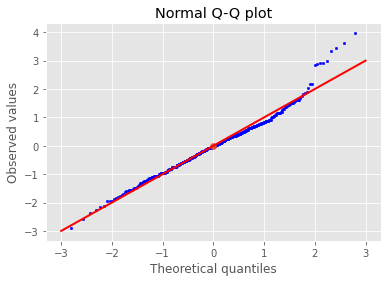

In [22]:
predictions = result_sm.predict(X)
residuals = y - predictions
plot_lm(predictions, residuals)

- There are a few large outliers, as shown in the Studentized residuals plot.
- The Q-Q plot shows that the distribution of the residuals is not Gaussian, especially for larger theoretical quantiles.
- The variance of the residuals is not constant (heteroscedasticity).

### 9.e

Since I cannot use the R methods for interaction, I expand the dataframe to take into account interaction among variables:

In [23]:
auto_interaction = copy.deepcopy(auto)

In [24]:
for main_col in cols_regression:
    cols_regression.remove(main_col)
    for second_col in cols_regression:
        interaction_col = auto[main_col] * auto[second_col]
        auto_interaction[f'{main_col}:{second_col}'] = interaction_col

In [25]:
auto_interaction.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin', 'name', 'acceleration:weight',
       'acceleration:displacement', 'acceleration:year',
       'acceleration:cylinders', 'acceleration:origin',
       'acceleration:horsepower', 'displacement:weight', 'displacement:year',
       'displacement:cylinders', 'displacement:origin',
       'displacement:horsepower', 'cylinders:weight', 'cylinders:year',
       'cylinders:origin', 'cylinders:horsepower', 'horsepower:weight',
       'horsepower:year', 'horsepower:origin'],
      dtype='object')

In [26]:
cols_interaction = list(set(auto_interaction.columns) - set(['name', 'mpg']))   # all columns except 'name' and 'mpg'
X = auto_interaction[cols_interaction]
X = sm.add_constant(X)
y = auto_interaction['mpg']
models = sm.OLS(y, X)
result_sm = models.fit()
print(result_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     115.9
Date:                Mon, 29 Mar 2021   Prob (F-statistic):          3.95e-157
Time:                        21:55:08   Log-Likelihood:                -932.42
No. Observations:                 392   AIC:                             1917.
Df Residuals:                     366   BIC:                             2020.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

The statistically significant interactions are those whose p_value is < 0.05:

In [27]:
result_sm.pvalues[result_sm.pvalues < 0.05]

displacement:origin        0.049027
acceleration:horsepower    0.045723
acceleration               0.028965
weight                     0.037987
horsepower:year            0.035106
origin                     0.006632
acceleration:origin        0.003030
horsepower                 0.043854
dtype: float64

There are 4 interactions (`displacement:weight, displacement:year, acceleration:origin, acceleration:year`) that are statistically significant.

<a id='exercise-10'></a>
## Exercise 10

This exercise uses the `Carseats` dataset.

In [28]:
carseats = pd.read_csv('data/Carseats.csv')

Description of the dataset:
    
- **Sales**: Unit sales (in thousands) at each location

- **CompPrice**: Price charged by competitor at each location

- **Income**: Community income level (in thousands of dollars)

- **Advertising**: Local advertising budget for company at each location (in thousands of dollars)

- **Population**: Population size in region (in thousands)

- **Price**: Price company charges for car seats at each site

- **ShelveLoc**: A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site

- **Age**: Average age of the local population

- **Education**: Education level at each location

- **Urban**: A factor with levels No and Yes to indicate whether the store is in an urban or rural location

- **US**: A factor with levels No and Yes to indicate whether the store is in the US or not

In [29]:
# Check null values
carseats.isna().sum()

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

There are no missing values.

In [30]:
carseats

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [31]:
carseats.dtypes

Sales          float64
CompPrice        int64
Income           int64
Advertising      int64
Population       int64
Price            int64
ShelveLoc       object
Age              int64
Education        int64
Urban           object
US              object
dtype: object

### 10. a-b-c-d

Predict `Sales` using `Price`, `Urban` and `US` as predictors. <br>
`Price` and `Urban` are qualitative variables. I need to convert them into one-hot encoded variables. <br>

#### Multicollinearity and dummy variables <span style="background-color: #FFC300">[Theory]</span>
When we convert a qualitative variable into one-hot encoded vectors, we need to leave out one of the dummies. In other words, one of the variables will be `[0, 0, 0, ... , 0]`. This is to avoid perfect multicollinearity among the variables: we would have the intercept colum (the one with only 1-s) to be the linear combination of all the other columns. This problem is called **the dummy variable trap**. To avoid it, we drop 1 variable.

Let's convert 'Urban' and 'US' in one-hot encoded variables:

In [32]:
# US
us_values = carseats['US']
enc = OneHotEncoder(handle_unknown='error', drop='first')    # drop: first to avoid the dummy variable trap
us_values_encoder = enc.fit(np.expand_dims(us_values, 1))       # 0: No, 1: Yes
us_values_onehot = us_values_encoder.transform(np.expand_dims(us_values, 1)).toarray()

In [33]:
# Urban
urban_values = carseats['Urban']
urban_values_onehot = enc.fit_transform(np.expand_dims(urban_values, 1)).toarray()    # 0: No, 1: Yes 

In [34]:
onehot_df = pd.DataFrame({'Urban one-hot': np.ravel(urban_values_onehot), 'US one-hot': np.ravel(us_values_onehot)})

In [35]:
X = pd.concat([carseats, onehot_df], axis=1)[['Price', 'Urban one-hot', 'US one-hot']]
X = sm.add_constant(X)
y = carseats['Sales']
model_carseats = sm.OLS(y, X)
result_carseats = model_carseats.fit()
print(result_carseats.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     41.52
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           2.39e-23
Time:                        21:55:08   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.0435      0.651     20.036

The $R^2$ is relatively low, 0.239. The coefficient of the `Urban` feature is not sifnigicant (p-value > 0.05).

The interpretation of the model is the following:
- `Sales` decrease with the increase in `Price`. 
- There is a significant correlation with the `US` variable. If the store is in the `US`, there is an increase of `Sales` by 1.20.
- There is no statistically significant relationship between `Urban` and `Sales`.

The formula of the multiple linear regression is: <br>
$\text{Sales} = 13.04 - 0.0545*\text{Price} - 0.0219*\text{Urban} + 1.20*\text{US} + \epsilon$

### 10.e

To fit a model with only the significant predictors, I remove the feature `Urban`:

In [36]:
X = pd.concat([carseats, onehot_df], axis=1)[['Price', 'US one-hot']]
X = sm.add_constant(X)
y = carseats['Sales']
model_carseats = sm.OLS(y, X)
result_carseats = model_carseats.fit()
print(result_carseats.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     62.43
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           2.66e-24
Time:                        21:55:08   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0308      0.631     20.652      0.0

### 10.f

The $R^2$ for the second model is higher than in the previous case (0.234 vs. 0.239). Removing the uncorrelated feature slightly helps increasing the performance of the model.

### 10.g

Using the second model, I look for the 95% confidence interval for the coefficients:

In [37]:
result_carseats.conf_int(0.05)

,0,1
const,11.79032,14.271265
Price,-0.06476,-0.044195
US one-hot,0.69152,1.707766


<a id='exercise-11'></a>
## Exercise 11

In this problem, we investigate the t-statistic for the null hypothesis $H_0$ in simple linear regression without an intercept. <br> The predictor and response are:

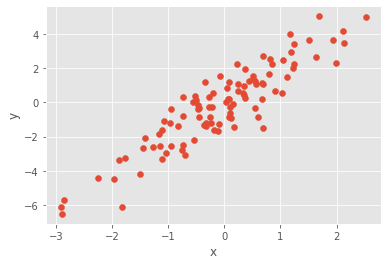

In [38]:
x = np.random.normal(0, 1, 100)
y = 2*x + np.random.normal(0, 1, 100)
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### 11.a
Perform single linear regression of y onto x without intercept:

In [39]:
class Linear_Regression_nointercept:
    def __init__(self):
        """
        Initialize parameters of the linear regression model without intercept. 
        """
        self.slope = None
        self.A = None
        self.t_statistics = []
        self.p_values = []
        self.SE = []
        
    def fit(self, x, y, print_statistics=False):
        """
        This function fits a linear regression model and stores the intercept and the coefficients.
        The arrays x and y are assumed to be row vectors.
        """
        X = np.zeros((x.shape[0], 1))
        X[:, 0] = x
        Y = y.reshape(-1, 1)
        self.A = np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(), X)), X.transpose()), Y)
        self.slope = self.A[0]
        self.N = x.shape[0]
        if print_statistics:
            self._hypothesis_testing(x, y)
        
    def predict(self, x):
        """
        This function predicts the response using the regression model.
        input x: row array, shape=(1, N) 
        output: column array, shape=(N, 1)
        """
        X = np.zeros((x.shape[0], 1))
        X[:, 0] = x
        return np.dot(X, self.A)
    
    def _hypothesis_testing(self, x, y):
        """
        Print a table for the t-statistics and p-value of the regression coefficients.
        The standard error of the parameters SE(..) are reported on page 66. 
        The t-scores of the parameters are calculated as B / SE(B).
        p-values are computed using a 2 sample t-test and N-2 degrees of freedom       
        """  
        N = y.shape[0]
        std_dev = math.sqrt(np.sum((y - np.ravel(self.predict(x)))**2) / (N - 1))    

        # Slope -----------------
        self.SE_slope = std_dev / math.sqrt(np.sum((x)**2))
        t_slope = self.slope / self.SE_slope        
        p_slope = stats.t.sf(np.abs(t_slope), N - 2) * 2       
        
        # Print value
        df_statistics = pd.DataFrame(data = {'': ['slope'],
                                             'values': [self.slope[0]],
                                             'standard error': [self.SE_slope],
                                             't-statistic': [t_slope[0]],
                                             'p-value': [p_slope[0]]})
                                             
        print(df_statistics)
        
    def print_model(self):
        print(f'The linear model is: y = {lm.slope[0]} x')

In [40]:
lm_nointercept = Linear_Regression_nointercept()
lm_nointercept.fit(y, x, print_statistics=True)

            values  standard error  t-statistic       p-value
0  slope  0.416474        0.018863     22.07913  8.050519e-40


In [41]:
lm_nointercept = Linear_Regression_nointercept()
lm_nointercept.fit(x, y, print_statistics=True)

            values  standard error  t-statistic       p-value
0  slope  1.995797        0.090393     22.07913  8.050519e-40


Fitting $x$ onto $y$ results in a slope equal to 2.11. This is a slight overestimation of the true value, which is 2. However, the p-value is < 0.05 and that means their relationship is significant. In  both cases, the t-statistics is very similar.

<a id='exercise-13'></a>
## Exercise 13
### 13.a-b-c

In [42]:
np.random.seed(1)
x = np.random.normal(0, 1, 100)
eps = np.random.normal(0, 0.25, 100)
y = -1 + 0.5*x + eps

- The length of vector y is 100
- $\beta_0$ = -1
- $\beta_1$ = 0.5

### 13.d

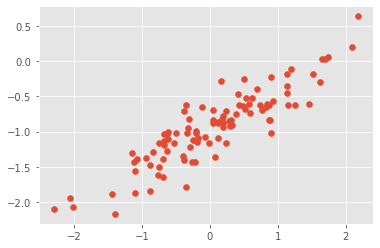

In [43]:
plt.scatter(x, y)
plt.show()

In [44]:
lm_13 = Linear_Regression()
lm_13.fit(x, y, print_statistics=True)

np.random.seed(1)
x = np.random.normal(0, 1, 100)
eps = np.random.normal(0, 0.25, 100)
y = -1 + 0.5*x + eps
X = np.zeros((x.shape[0], 2))
X[:, 0] = x
X = sm.add_constant(x)
model_standardnoise = sm.OLS(y, X)
result_standardnoise = model_standardnoise.fit()
print(result_standardnoise.summary())

                values  standard error  t-statistic       p-value
0  intercept -0.963247        0.023375   -41.207642  1.060214e-63
1      slope  0.523857        0.026347    19.883261  3.613841e-36
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     391.4
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           5.39e-36
Time:                        21:55:09   Log-Likelihood:                 4.1908
No. Observations:                 100   AIC:                            -4.382
Df Residuals:                      98   BIC:                            0.8288
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
            

The predicted value of the intercept is lower than the real one, while the slope is slightly higher. In both cases, the p-value is significant.

### 13.e

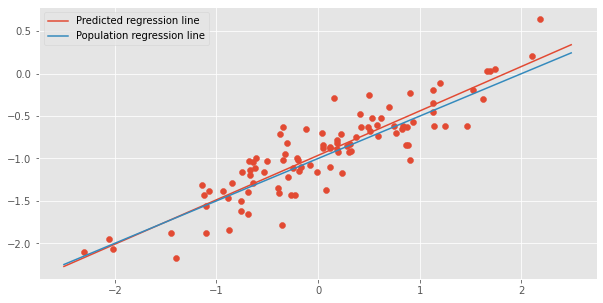

In [45]:
X = np.arange(-2.5, 2.5, 0.01)
X = X.reshape(X.shape[0], 1)
X = sm.add_constant(X)
regression_line_hat = result_standardnoise.predict(X)

lm_13_population = Linear_Regression()
lm_13_population.A = np.array([[-1], [0.5]])
regression_line = lm_13_population.predict(np.arange(-2.5, 2.5, 0.01))  # population regression line

plt.figure(figsize=(10, 5))
plt.scatter(x, y)
plt.plot(X[:, 1], regression_line_hat)
plt.plot(np.arange(-2.5, 2.5, 0.01), regression_line)
plt.legend(['Predicted regression line', 'Population regression line'])
plt.show()

### 13.g
Fit a polynomial regression that predicts $y$ using $x$ and $x^2$:

In [46]:
X = np.zeros((x.shape[0], 2))
X[:, 0] = x
X[:, 1] = x**2
X = sm.add_constant(X)
model_polynomial = sm.OLS(y, X)
result_polynomial = model_polynomial.fit()
print(result_polynomial.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     193.8
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           1.32e-34
Time:                        21:55:09   Log-Likelihood:                 4.2077
No. Observations:                 100   AIC:                            -2.415
Df Residuals:                      97   BIC:                             5.400
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9663      0.029    -33.486      0.0

There is no evidence that the additional quadratic term improves the result. The p-value for the coefficient of the quadratic parameter is not significant.

### 13.h
Repeat the whole procedure *reducing* the noise in the data:

In [47]:
np.random.seed(1)
x = np.random.normal(0, 1, 100)
eps = np.random.normal(0, 0.01, 100)
y = -1 + 0.5*x + eps
X = sm.add_constant(x)
model_lessnoise = sm.OLS(y, X)
result_lessnoise = model_lessnoise.fit()
print(result_lessnoise.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.237e+05
Date:                Mon, 29 Mar 2021   Prob (F-statistic):          2.16e-166
Time:                        21:55:09   Log-Likelihood:                 326.08
No. Observations:                 100   AIC:                            -648.2
Df Residuals:                      98   BIC:                            -642.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9985      0.001  -1062.519      0.0

### 13.i
Repeat the whole procedure *increasing* the noise in the data:

In [48]:
np.random.seed(1)
x = np.random.normal(0, 1, 100)
eps = np.random.normal(0, 0.9, 100)
y = -1 + 0.5*x + eps
X = sm.add_constant(x)
model_morenoise = sm.OLS(y, X)
result_morenoise = model_morenoise.fit()
print(result_morenoise.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     37.77
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           1.72e-08
Time:                        21:55:09   Log-Likelihood:                -123.90
No. Observations:                 100   AIC:                             251.8
Df Residuals:                      98   BIC:                             257.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8677      0.085    -10.259      0.0

When there is *less* noise, the model is much more accurate ($R^2$ = 1 when the noise is very small). When there is *more* noise, the model i less accurate ($R^2$ is decreased to 0.278). The p-value is sitll significant in both cases.

### 13.j
The 95% confidence intervals for the three different scenarios are:

In [49]:
more_noise_ci = np.ravel(result_morenoise.conf_int(0.05))
less_noise_ci = np.ravel(result_lessnoise.conf_int(0.05))
std_noise_ci = np.ravel(result_standardnoise.conf_int(0.05))
BOLD = '\033[1m'
END_BOLD = '\033[0m'

label_noise = ['Standard noise', 'Less noise', 'More noise']
list_ci = [std_noise_ci, less_noise_ci, more_noise_ci]
for idx in range(0, 3):
    print(f'{BOLD} {label_noise[idx]} {END_BOLD}')
    table = PrettyTable()
    table.field_names = ['', '[0.025', '0.975]']
    table.add_row(['Intercept', list_ci[idx][0], list_ci[idx][1]])
    table.add_row(['Slope', list_ci[idx][2], list_ci[idx][3]])
    print(table, '\n')

 Standard noise 
+-----------+---------------------+---------------------+
|           |        [0.05        |        0.95]        |
+-----------+---------------------+---------------------+
| Intercept |  -1.00987048234054  | -0.9166227528103588 |
|   Slope   | 0.47130668842384216 |  0.5764068784017438 |
+-----------+---------------------+---------------------+ 

 Less noise 
+-----------+---------------------+---------------------+
|           |        [0.05        |        0.95]        |
+-----------+---------------------+---------------------+
| Intercept | -1.0003948192936214 | -0.9966649101124142 |
|   Slope   | 0.49885226753695355 |  0.5030562751360697 |
+-----------+---------------------+---------------------+ 

 More noise 
+-----------+---------------------+---------------------+
|           |        [0.05        |        0.95]        |
+-----------+---------------------+---------------------+
| Intercept | -1.0355337364259447 | -0.6998419101172921 |
|   Slope   |  0.39670407

<a id='exercise-14'></a>
## Exercise 14
This exercise focuses on *collinearity*

### 14.a

In [50]:
np.random.seed(1)
x1 = np.random.uniform(0, 1, 100)
x2 = 0.5 * x1 + np.random.normal(0, 1, 100) / 10
y = 2 + 2 * x1 + 0.3 * x2 + np.random.normal(0, 1, 100)

The regression line can be written as: 

$ Y = \beta_0 + \beta_1 \cdot x1 + \beta_2 \cdot x2 + \epsilon $ 

where:
- $\beta_0$ = 2
- $\beta_1$ = 2
- $\beta_2$ = 0.3

### 14.b
Relationship between $x1$ and $x2$:

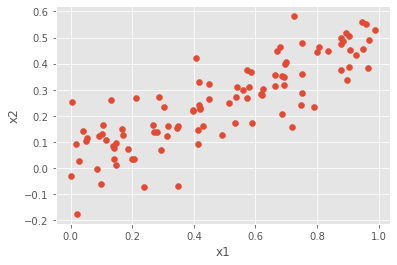

In [51]:
plt.scatter(x1, x2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

There is a clear correlation between x1 and x2. Specifically, the correlation is:

In [52]:
scipy.stats.pearsonr(x1, x2)[0]

0.8390596222844909

### 14.c
Fit a least squares regression using the $x1$ and $x2$:

In [53]:
np.random.seed(1)
X = np.zeros((x1.shape[0], 2))
X[:, 0] = x1
X[:, 1] = x2
X = sm.add_constant(X)
model_14 = sm.OLS(y, X)
result_14 = model_14.fit()
print(result_14.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     17.09
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           4.40e-07
Time:                        21:55:09   Log-Likelihood:                -142.34
No. Observations:                 100   AIC:                             290.7
Df Residuals:                      97   BIC:                             298.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1893      0.199     11.021      0.0

The linear model is not very accurate. <br>
- The intercept $\beta_0$ is fairly accurate (2.18 instead of 2).
- $\beta_1$ is not accurate (0.7 instead of 2)
- $\beta_2$ is not accurate (2.50 instead of 0.3)
- The p-value for $\beta_1$ is higher than 0.05, so we cannot reject the null hypothesis $H_0 : \beta_1 = 0$.
- The p-value for $\beta_2$ is lower than 0.05, so we can reject the null hypothesis $H_0 : \beta_2 = 0$.


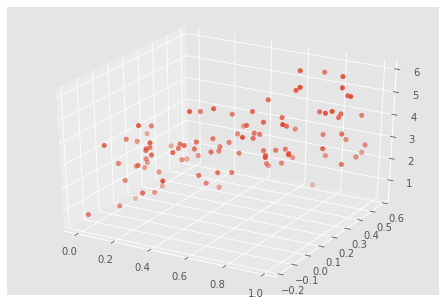

In [72]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x1, x2, y)
plt.show()

### 14.d
Only using $x1$ to predict $y$:

In [74]:
X = np.zeros((x1.shape[0], 1))
X[:, 0] = x1
X = sm.add_constant(X)
model_14 = sm.OLS(y, X)
result_14 = model_14.fit()
print(result_14.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     28.26
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           6.68e-07
Time:                        22:15:00   Log-Likelihood:                -144.76
No. Observations:                 100   AIC:                             293.5
Df Residuals:                      98   BIC:                             298.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2486      0.201     11.209      0.0

When only $x1$ is used:
- $R^2$ is slightly lower.
- The p-value of $\beta_1$ is lower than 0.05, so we can reject the null hypothesis $H_0 : \beta_1 = 0$.
- $\beta_1$ is closer to its real value.

### 14.e
Only using $x2$:

In [76]:
X = np.zeros((x2.shape[0], 1))
X[:, 0] = x2
X = sm.add_constant(X)
model_14 = sm.OLS(y, X)
result_14 = model_14.fit()
print(result_14.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     32.87
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           1.09e-07
Time:                        22:19:30   Log-Likelihood:                -142.97
No. Observations:                 100   AIC:                             289.9
Df Residuals:                      98   BIC:                             295.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2655      0.187     12.145      0.0

When only $x2$ is used:
- $R^2$ is slightly lower.
- The p-value of $\beta_2$ is lower than 0.05, so we can reject the null hypothesis $H_0 : \beta_2 = 0$.
- $\beta_2$ is much higher than its real value (3.56 instead of 0.3).

### 14.f

To see if results contradict each other, we need to look at the p-values:

In c):
- There is a 0.271% chance that the null hypothesis $H : \beta_1 = 0$ is true.  

In d)
- There is 0% chance that the null hypothesis $H : \beta_1 = 0$ is true.  

Result contradict each other.

<a id='exercise-15'></a>
## Exercise 15
This problem involves the Boston dataset. We will try to predict the crime per capita rate.

In [84]:
boston_data = pd.read_excel('data/boston.xls')
boston_descr = load_boston()['DESCR']
print(boston_descr)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### 15.a

Fit a simple linear regression for each predictor and comment. Since I need to do it for every predictor, I use the custom function I built in Exercise 8 because it returns a simple table as result (instead of the big table that statmodels.OLS returns).

In [169]:
response = boston_data['CRIM'].values
predictors = list(boston_data.columns)
predictors.remove('CRIM')
predictors_a_dict = dict()
r2_score_a_dict = dict()
for predictor in predictors:
    lm = Linear_Regression()
    print(f'{predictor}: ')
    lm.fit(boston_data[predictor].values, response, print_statistics=True)
    predictors_a_dict[predictor] = lm.slope[0]
    y_pred = lm.predict(boston_data[predictor])
    r2_score_a_dict[predictor] = r2_score(response, np.ravel(y_pred))
    print()

ZN: 
                values  standard error  t-statistic       p-value
0  intercept  4.453694        0.416804    10.685331  3.679188e-24
1      slope -0.073935        0.016079    -4.598332  5.392217e-06

INDUS: 
                values  standard error  t-statistic       p-value
0  intercept -2.063743        0.666567    -3.096075  2.070157e-03
1      slope  0.509776        0.050974    10.000755  1.334225e-21

CHAS: 
                values  standard error  t-statistic       p-value
0  intercept  3.744447        0.395719     9.462395  1.148668e-19
1      slope -1.892777        1.504624    -1.257974  2.089838e-01

NOX: 
                 values  standard error  t-statistic       p-value
0  intercept -13.719883        1.697796    -8.080997  4.790263e-15
1      slope  31.248532        2.996219    10.429321  3.430907e-23

RM: 
                 values  standard error  t-statistic       p-value
0  intercept  20.481804        3.361141     6.093705  2.193590e-09
1      slope  -2.684051        0.531

The only parameter that is not statistically significant is the intercept of `CHAS`.

### 15.b

Fit a multiple linear regression using all the predictors and comment. <br>
For this task, I use the library `statsmodel.OLS`.

In [139]:
X = boston_data[predictors].values
X = sm.add_constant(X)
y = np.transpose(np.expand_dims(response, 0))
lm_15 = sm.OLS(y, X)
results_15 = lm_15.fit()
print(results_15.summary())
print()
significant_params = []
non_significant_params = []

predictors_b_dict = dict()
for idx, param in enumerate(results_15.params[1:]):
    predictors_b_dict[predictors[idx]] = param 
    
for idx, pvalue in enumerate(results_15.pvalues[1:]):
    if pvalue < 0.05:
        significant_params.append(predictors[idx])
    else:
        non_significant_params.append(predictors[idx])
print(f'Significant parameters: \n{significant_params} \n')
print(f'Non-significant parameters: \n{non_significant_params}')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     31.47
Date:                Sat, 03 Apr 2021   Prob (F-statistic):           1.57e-56
Time:                        14:45:03   Log-Likelihood:                -1653.3
No. Observations:                 506   AIC:                             3335.
Df Residuals:                     492   BIC:                             3394.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.0332      7.235      2.354      0.0

### 15.c

How does a) compare to b)? Plot the results of simple linear regression per predictor on the x-axis and the results of multiple linear regression per predictor on the y-axis.

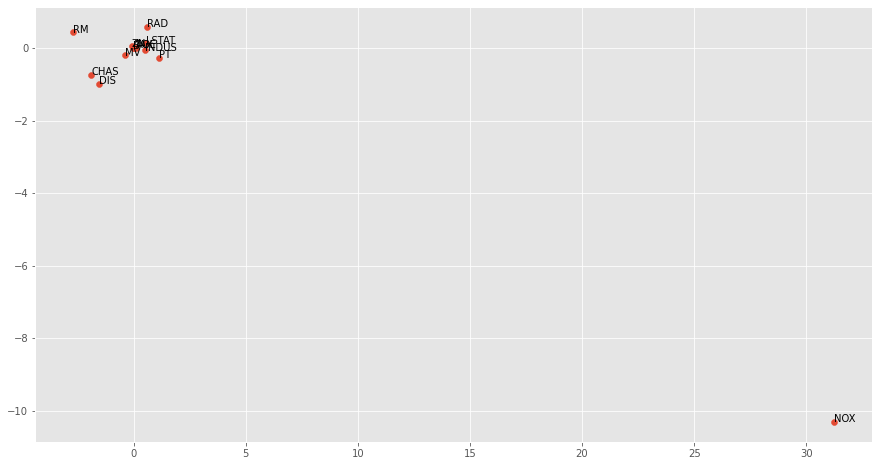

In [143]:
fig, ax = plt.subplots(figsize=(15, 8))
x = list(predictors_a_dict.values())
y = list(predictors_b_dict.values())
ax.scatter(x, y)

for i, txt in enumerate(list(predictors_a_dict.keys())):
    ax.annotate(txt, (x[i], y[i]))
plt.show()

### 15.d
To see if there's evidence of non-linear association between any of the predictors and the response, I compare the p-value for the simple linear regression and those for the polynomial regression reported in the book:

To create the X matrix for the polynomial regression, I use the function `PolynomialFeatures(degrees=3)` from `scikit-learn`. This method automatically adds the intercept column.

In [179]:
polynomial_features= PolynomialFeatures(degree=3)
response = boston_data['CRIM']
r2_score_b_dict = dict()
results_fit_dict = dict()
for predictor in predictors:
    X = np.transpose(np.expand_dims(boston_data[predictor], 0))
    X = polynomial_features.fit_transform(X)
    result = sm.OLS(response, X).fit()
    y_pred = result.predict(X)
    r2_score_b_dict[predictor] = r2_score(response, y_pred)
    results_fit_dict[predictor] = dict()
    results_fit_dict[predictor]['coefficients'] = result.params
    results_fit_dict[predictor]['p_values'] = result.pvalues

In [183]:
linear_predictors = []
non_linear_predictors = []
for predictor in predictors:
    print(f'{predictor}')
    table = PrettyTable()
    table.field_names = ['', 'coefficient', 'p-value']
    table.add_row(['B_1', results_fit_dict[predictor]['coefficients'][1], results_fit_dict[predictor]['p_values'][1]])
    table.add_row(['B_2', results_fit_dict[predictor]['coefficients'][2], results_fit_dict[predictor]['p_values'][2]])
    table.add_row(['B_3', results_fit_dict[predictor]['coefficients'][3], results_fit_dict[predictor]['p_values'][3]])
    if ((results_fit_dict[predictor]['p_values'][2]) or (results_fit_dict[predictor]['p_values'][3])) < 0.05:
        non_linear_predictors.append(predictor)
    elif results_fit_dict[predictor]['p_values'][1] < 0.05:
        linear_predictors.append(predictor)
    print(table, '\n')

ZN
+-----+------------------------+---------------------+
|     |      coefficient       |       p-value       |
+-----+------------------------+---------------------+
| B_1 |  -0.3321884150131865   | 0.00261229622557879 |
| B_2 |  0.006482633657862245  | 0.09375049857179296 |
| B_3 | -3.775792530543718e-05 | 0.22953861906077608 |
+-----+------------------------+---------------------+ 

INDUS
+-----+-----------------------+------------------------+
|     |      coefficient      |        p-value         |
+-----+-----------------------+------------------------+
| B_1 |  -1.9652130583718204  | 5.297058454608394e-05  |
| B_2 |  0.25193730567843386  |  3.42018446785424e-10  |
| B_3 | -0.006976008674588906 | 1.1964052118427226e-12 |
+-----+-----------------------+------------------------+ 

CHAS
+-----+--------------------+--------------------+
|     |    coefficient     |      p-value       |
+-----+--------------------+--------------------+
| B_1 | 111433708326157.34 | 0.6812801800803026 

In [184]:
print('There is evidence of non-linear association for:')
print(non_linear_predictors)
print('There is evidence of linear association for:')
print(linear_predictors)

There is evidence of non-linear association for:
['INDUS', 'NOX', 'AGE', 'DIS', 'PT', 'MV']
There is evidence of linear association for:
['ZN']
